In [6]:
from src.data.hf_cleaned_booksum import DataLoader
from src.indexing import iterative_chunk , create_vbd

data_loader = DataLoader()



In [7]:
def split_text_into_words (text) : 
    return text.split()

def split_text_into_sentences(text) : 
    return text.split(".")

In [8]:
# Function to find the optimal number of clusters for KMeans using silhouette score
def find_optimal_kmeans_clusters(embeddings, cluster_range):
    best_score = -1
    best_k = 2
    best_labels = None
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels) if len(set(labels)) > 1 else float('nan')
        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels
    return best_k, best_labels, best_score

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from src.data.hf_cleaned_booksum import DataLoader
from tqdm import tqdm
import pandas as pd

# Step 1: Load data
data_loader = DataLoader()
number_of_books = data_loader.get_number_of_books()

# Initialize lists to store results
results = {
    "KMeans": [],
    "Agglomerative": [],
    "DBSCAN": []
}



# Step 2-5: Process each book
for index in tqdm(range(number_of_books), desc="Processing books"):
    book_summary_couple = data_loader.get_book_summary_couple(index)
    doc = book_summary_couple["book"]

    # Step 2: Chunk the document
    words = split_text_into_words(doc)
    chunks, avg_chunk_length = iterative_chunk(words, max_length=300, overlap=50)  # Adjust chunk size and overlap as needed

    # Step 3: Create embeddings
    emb_model = "nomic-embed-text"  # Replace with your actual model
    vdb = create_vbd(chunks, emb_model)
    
    # Extract embeddings from the vector database
    embeddings = [entry["embedding"] for entry in vdb if len(entry["embedding"]) > 0]

    # Skip if no valid embeddings
    if len(embeddings) == 0:
        continue

    # Convert to numpy array
    embeddings = np.array(embeddings)

    # Step 4: Clustering using three methods
    clustering_methods = {
        "Agglomerative": AgglomerativeClustering,
        "DBSCAN": DBSCAN(eps=0.5, min_samples=5)
    }

    # Optimize KMeans for silhouette score
    try:
        best_k, best_labels, best_silhouette = find_optimal_kmeans_clusters(embeddings, range(2, 11))  # Adjust range as needed
        number_of_clusters = best_k
        davies_bouldin = davies_bouldin_score(embeddings, best_labels) if len(set(best_labels)) > 1 else float('nan')
        calinski_harabasz = calinski_harabasz_score(embeddings, best_labels) if len(set(best_labels)) > 1 else float('nan')

        # Store the optimized KMeans results
        results["KMeans"].append({
            "Book Index": index,
            "Optimal Clusters": best_k,
            "Silhouette Score": best_silhouette,
            "Davies-Bouldin Index": davies_bouldin,
            "Calinski-Harabasz Index": calinski_harabasz
        })
    except Exception as e:
        print(f"Error clustering with KMeans for book index {index}: {e}")

    for method_name, clustering_model in clustering_methods.items():
        try:
            if method_name == "Agglomerative" : 
                clustering_model = AgglomerativeClustering(n_clusters=best_k)
            labels = clustering_model.fit_predict(embeddings)

            # Step 5: Evaluate clusters
            silhouette = silhouette_score(embeddings, labels) if len(set(labels)) > 1 else float('nan')
            davies_bouldin = davies_bouldin_score(embeddings, labels) if len(set(labels)) > 1 else float('nan')
            calinski_harabasz = calinski_harabasz_score(embeddings, labels) if len(set(labels)) > 1 else float('nan')

            # Store the results
            results[method_name].append({
                "Book Index": index,
                "Silhouette Score": silhouette,
                "Davies-Bouldin Index": davies_bouldin,
                "Calinski-Harabasz Index": calinski_harabasz
            })

        except Exception as e:
            print(f"Error clustering with {method_name} for book index {index}: {e}")




Processing books: 100%|██████████| 151/151 [33:50<00:00, 13.45s/it]


In [17]:
# Step 6: Aggregate and compare results
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'blue' if val > 90 else 'black'
    return 'color: % s' % color
# Convert results to DataFrame for better visualization and analysis
results_df = {}
for method_name in results:
    results_df[method_name] = pd.DataFrame(results[method_name])

# Display results
for method_name, df in results_df.items():
    print(df)

     Book Index  Optimal Clusters  Silhouette Score  Davies-Bouldin Index  \
0             0                 2          0.054030              3.999960   
1             1                 2          0.054245              4.012504   
2             2                 2          0.264295              2.393421   
3             3                 2          0.061838              3.845181   
4             4                 2          0.060294              4.172635   
..          ...               ...               ...                   ...   
146         146                 2          0.084646              3.320918   
147         147                 3          0.052321              3.758152   
148         148                 2          0.274374              2.320434   
149         149                 5          0.060311              2.940028   
150         150                 2          0.090430              3.549103   

     Calinski-Harabasz Index  
0                  19.144226  
1            

   Book Index  Optimal Clusters  Silhouette Score  Davies-Bouldin Index  \
0           0               2.0          0.054030              3.999960   
1           1               2.0          0.054245              4.012504   
2           2               2.0          0.264295              2.393421   
3           3               2.0          0.061838              3.845181   
4           4               2.0          0.060294              4.172635   

   Calinski-Harabasz Index  Method  
0                19.144226  KMeans  
1                47.047061  KMeans  
2                15.908084  KMeans  
3                56.723599  KMeans  
4                17.001822  KMeans  


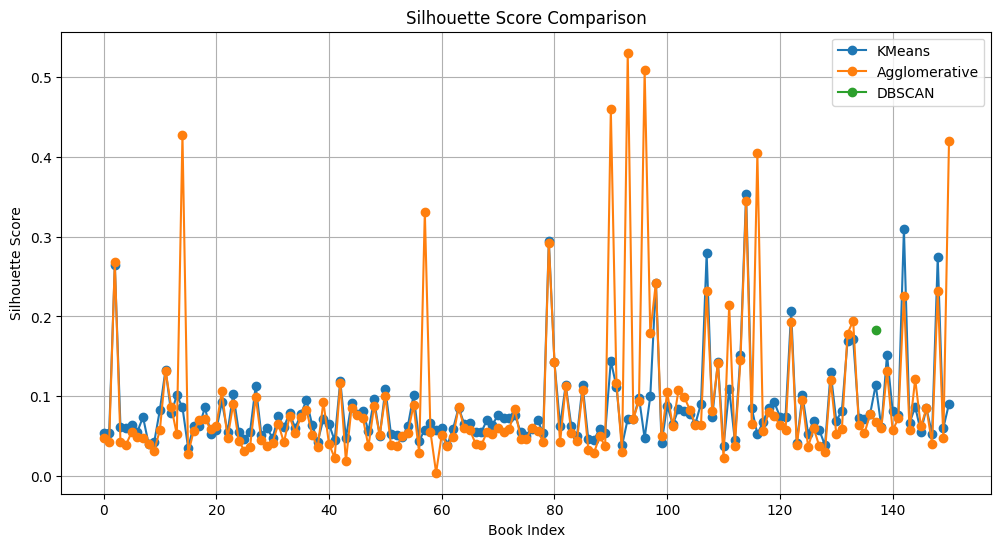

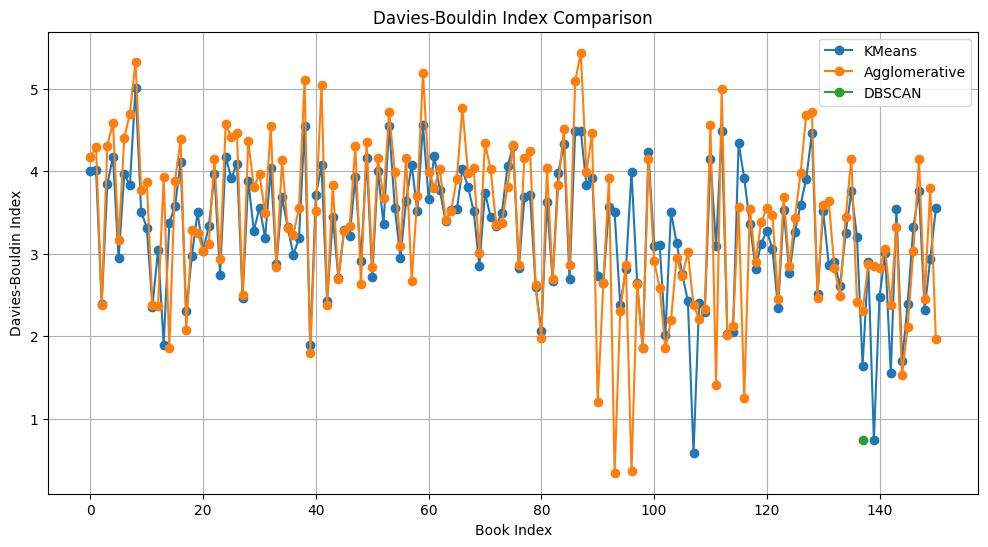

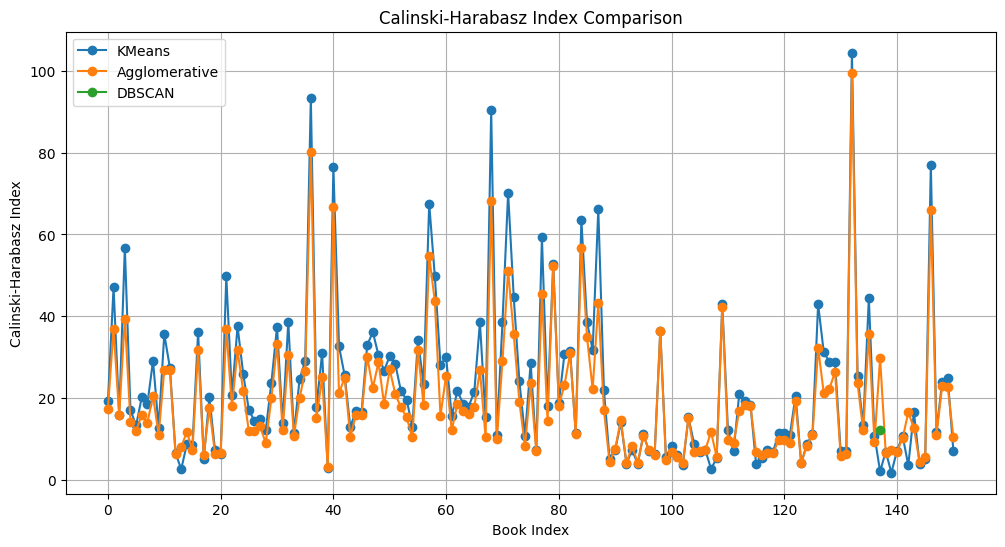

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine the DataFrames for easier comparison
combined_results = pd.DataFrame()

for method_name, df in results_df.items():
    df['Method'] = method_name
    combined_results = pd.concat([combined_results, df], ignore_index=True)

# Check the combined DataFrame structure
print(combined_results.head())

# Plotting function to visualize the differences between clustering methods
def plot_comparison(metric, title, ylabel):
    plt.figure(figsize=(12, 6))
    for method_name in combined_results['Method'].unique():
        method_df = combined_results[combined_results['Method'] == method_name]
        plt.plot(method_df['Book Index'], method_df[metric], marker='o', label=method_name)

    plt.title(title)
    plt.xlabel('Book Index')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot comparisons for each evaluation metric
plot_comparison('Silhouette Score', 'Silhouette Score Comparison', 'Silhouette Score')
plot_comparison('Davies-Bouldin Index', 'Davies-Bouldin Index Comparison', 'Davies-Bouldin Index')
plot_comparison('Calinski-Harabasz Index', 'Calinski-Harabasz Index Comparison', 'Calinski-Harabasz Index')


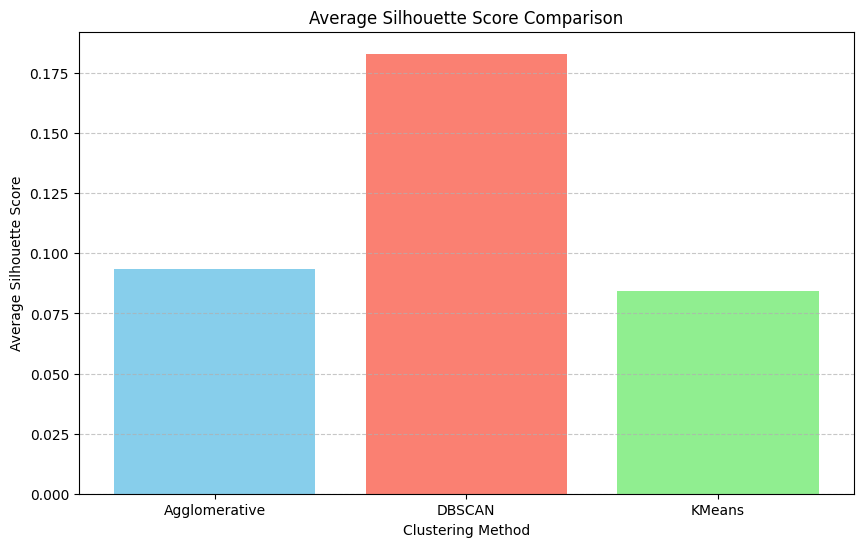

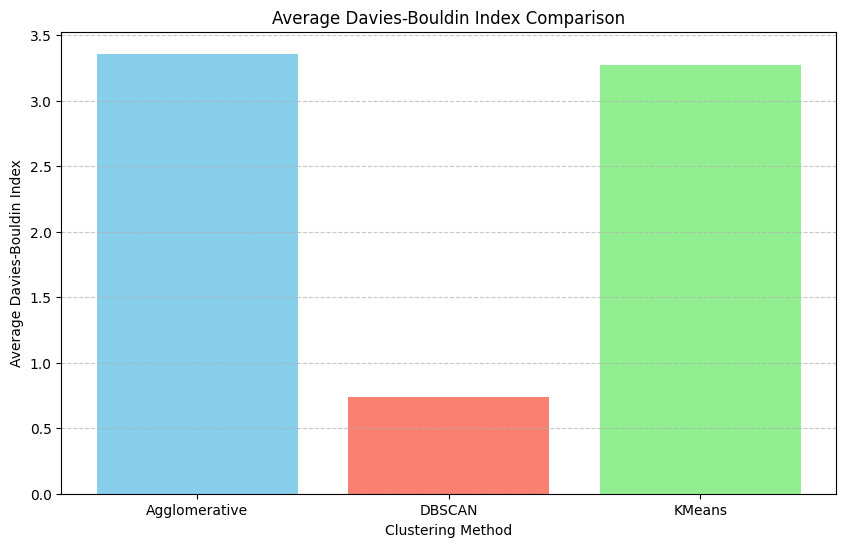

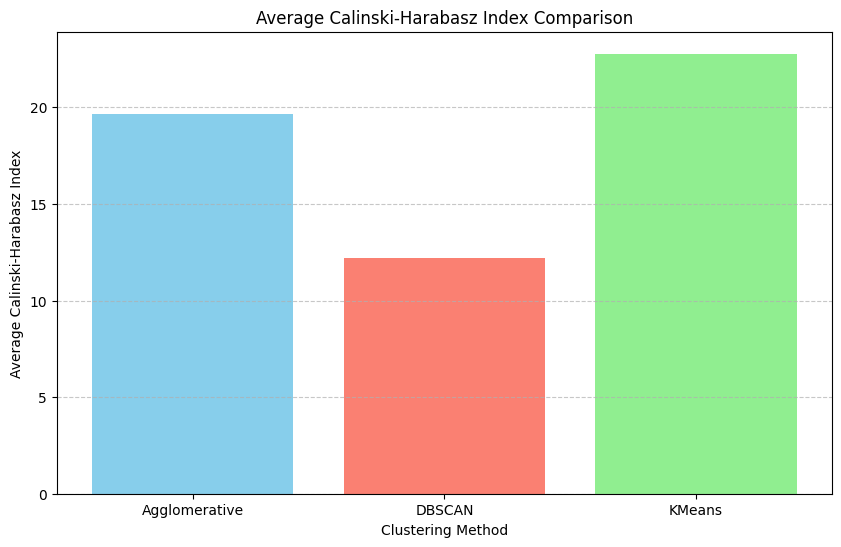

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine the DataFrames for easier comparison
combined_results = pd.DataFrame()

for method_name, df in results_df.items():
    df['Method'] = method_name
    combined_results = pd.concat([combined_results, df], ignore_index=True)

# Calculate the average scores for each method
average_scores = combined_results.groupby('Method').mean(numeric_only=True).reset_index()

# Function to create bar plots for average scores
def plot_average_comparison(metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(average_scores['Method'], average_scores[metric], color=['skyblue', 'salmon', 'lightgreen'])
    plt.title(title)
    plt.xlabel('Clustering Method')
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot comparisons for average scores of each evaluation metric
plot_average_comparison('Silhouette Score', 'Average Silhouette Score Comparison', 'Average Silhouette Score')
plot_average_comparison('Davies-Bouldin Index', 'Average Davies-Bouldin Index Comparison', 'Average Davies-Bouldin Index')
plot_average_comparison('Calinski-Harabasz Index', 'Average Calinski-Harabasz Index Comparison', 'Average Calinski-Harabasz Index')


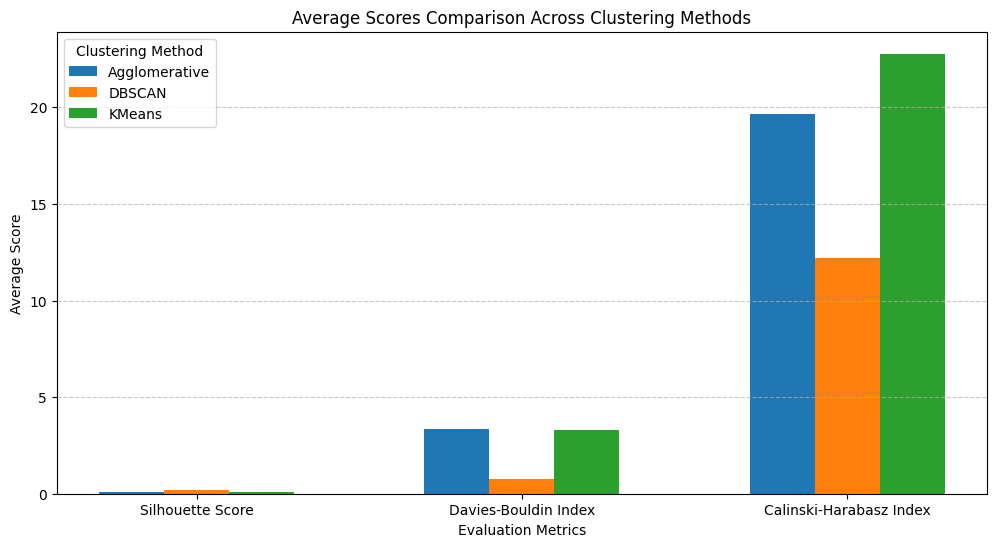

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Combine the DataFrames for easier comparison
combined_results = pd.DataFrame()

for method_name, df in results_df.items():
    df['Method'] = method_name
    combined_results = pd.concat([combined_results, df], ignore_index=True)

# Calculate the average scores for each method
average_scores = combined_results.groupby('Method').mean(numeric_only=True).reset_index()

# Metrics and clustering methods
metrics = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']
methods = average_scores['Method']

# Set up the bar plot
plt.figure(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(metrics))

# Plot bars for each method
for i, method in enumerate(methods):
    plt.bar(x + i * bar_width, average_scores.loc[average_scores['Method'] == method, metrics].values[0], 
            width=bar_width, label=method)

# Set plot details
plt.xlabel('Evaluation Metrics')
plt.ylabel('Average Score')
plt.title('Average Scores Comparison Across Clustering Methods')
plt.xticks(x + bar_width, metrics)
plt.legend(title='Clustering Method')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


In [21]:
df.to_csv("clustering_benchmark_without_pca.csv")

In [49]:
from scipy.spatial.distance import cdist
import numpy as np 
# Step 1: Load data
data_loader = DataLoader()
number_of_books = data_loader.get_number_of_books()

# Initialize lists to store results
results = {
    "KMeans": [],
    "Agglomerative": [],
    "DBSCAN": []
}

# Function to calculate cluster centroid distances
def calculate_centroid_distances(embeddings, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([embeddings[labels == label].mean(axis=0) for label in unique_labels])
    if len(centroids) < 2:
        return float('nan'), float('nan'), float('nan')
    distances = cdist(centroids, centroids)
    distances = distances[np.triu_indices_from(distances, k=1)]  # Take upper triangle without diagonal
    return distances.mean(), distances.std(), np.median(distances)

# Step 2-5: Process each book
for index in tqdm(range(number_of_books), desc="Processing books"):
    book_summary_couple = data_loader.get_book_summary_couple(index)
    doc = book_summary_couple["book"]

    # Step 2: Chunk the document
    words = split_text_into_words(doc)
    chunks, avg_chunk_length = iterative_chunk(words, max_length=300, overlap=50)  # Adjust chunk size and overlap as needed

    # Step 3: Create embeddings
    emb_model = "nomic-embed-text"  # Replace with your actual model
    vdb = create_vbd(chunks, emb_model)
    
    # Extract embeddings from the vector database
    embeddings = [entry["embedding"] for entry in vdb if len(entry["embedding"]) > 0]

    # Skip if no valid embeddings
    if len(embeddings) == 0:
        continue

    # Convert to numpy array
    embeddings = np.array(embeddings)

    # Step 4: Clustering using three methods
    clustering_methods = {
        "Agglomerative": AgglomerativeClustering,
        "DBSCAN": DBSCAN(eps=0.5, min_samples=5)
    }

    # Optimize KMeans for silhouette score
    try:
        best_k, best_labels, best_silhouette = find_optimal_kmeans_clusters(embeddings, range(2, 11))  # Adjust range as needed
        number_of_clusters = best_k
        davies_bouldin = davies_bouldin_score(embeddings, best_labels) if len(set(best_labels)) > 1 else float('nan')
        calinski_harabasz = calinski_harabasz_score(embeddings, best_labels) if len(set(best_labels)) > 1 else float('nan')

        # Statistics for KMeans
        cluster_counts = np.bincount(best_labels)
        cluster_count_stats = {
            'min': cluster_counts.min(),
            'max': cluster_counts.max(),
            'mean': cluster_counts.mean(),
            'std': cluster_counts.std()
        }
        centroid_dist_mean, centroid_dist_std, centroid_dist_median = calculate_centroid_distances(embeddings, best_labels)

        # Store the optimized KMeans results
        results["KMeans"].append({
            "Book Index": index,
            "Number Clusters": best_k,
            "Silhouette Score": best_silhouette,
            "Davies-Bouldin Index": davies_bouldin,
            "Calinski-Harabasz Index": calinski_harabasz,
            'Cluster Population min': cluster_counts.min(),
            'Cluster Population max': cluster_counts.max(),
            'Cluster Population mean': cluster_counts.mean(),
            'Cluster Population std': cluster_counts.std() ,
            "Centroid Distances mean": centroid_dist_mean,
            "Centroid Distances std": centroid_dist_std,
            "Centroid Distances median": centroid_dist_median 
        })
    except Exception as e:
        print(f"Error clustering with KMeans for book index {index}: {e}")

    for method_name, clustering_model in clustering_methods.items():
        try:
            if method_name == "Agglomerative" : 
                clustering_model = AgglomerativeClustering(n_clusters=best_k)
            labels = clustering_model.fit_predict(embeddings)

            # Step 5: Evaluate clusters
            silhouette = silhouette_score(embeddings, labels) if len(set(labels)) > 1 else float('nan')
            davies_bouldin = davies_bouldin_score(embeddings, labels) if len(set(labels)) > 1 else float('nan')
            calinski_harabasz = calinski_harabasz_score(embeddings, labels) if len(set(labels)) > 1 else float('nan')

            # Statistics for clusters
            cluster_counts = np.bincount(labels + (labels.min() < 0))  # Adjust if there are -1 labels (for DBSCAN noise)
            cluster_count_stats = {
                'min': cluster_counts.min(),
                'max': cluster_counts.max(),
                'mean': cluster_counts.mean(),
                'std': cluster_counts.std()
            }
            centroid_dist_mean, centroid_dist_std, centroid_dist_median = calculate_centroid_distances(embeddings, labels)

            # Store the results
            results[method_name].append({
                "Book Index": index,
                "Number of Clusters": len(set(labels)),
                "Silhouette Score": silhouette,
                "Davies-Bouldin Index": davies_bouldin,
                "Calinski-Harabasz Index": calinski_harabasz,
                "Book Index": index,
                "Number Clusters": best_k,
                "Silhouette Score": best_silhouette,
                "Davies-Bouldin Index": davies_bouldin,
                "Calinski-Harabasz Index": calinski_harabasz,
                'Cluster Population min': cluster_counts.min(),
                'Cluster Population max': cluster_counts.max(),
                'Cluster Population mean': cluster_counts.mean(),
                'Cluster Population std': cluster_counts.std() ,
                "Centroid Distances mean": centroid_dist_mean,
                "Centroid Distances std": centroid_dist_std,
                "Centroid Distances median": centroid_dist_median 
                })

        except Exception as e:
            print(f"Error clustering with {method_name} for book index {index}: {e}")


Processing books: 100%|██████████| 151/151 [00:39<00:00,  3.80it/s]


In [50]:
# Combine the results into DataFrames for analysis
results_df = {}
for method_name in results:
    results_df[method_name] = pd.DataFrame(results[method_name])

# Save results to CSV files
for method_name, df in results_df.items():
    df.to_csv(f"{method_name}_clustering_results.csv", index=False)




In [51]:
import pandas as pd
import numpy as np

# Assuming the clustering results have been saved to the following CSV files
file_names = {
    "KMeans": "KMeans_clustering_results.csv",
    "Agglomerative": "Agglomerative_clustering_results.csv",
    "DBSCAN": "DBSCAN_clustering_results.csv"
}

# Load data into DataFrames
results_df = {method: pd.read_csv(file) for method, file in file_names.items()}

# Function to calculate averages of all relevant metrics
def calculate_averages(df):
    metrics = [
    "Number of Clusters", 
    "Silhouette Score", 
    "Davies-Bouldin Index", 
    "Calinski-Harabasz Index", 
    "Cluster Population min", 
    "Cluster Population max", 
    "Cluster Population mean", 
    "Cluster Population std", 
    "Centroid Distances mean", 
    "Centroid Distances std", 
    "Centroid Distances median"
]
    
    # Filter columns that exist in the DataFrame
    available_metrics = [metric for metric in metrics if metric in df.columns]
    
    # Calculate averages
    averages = df[available_metrics].mean()
    
    return averages

# Calculate averages for all methods
averages_df = pd.DataFrame({method: calculate_averages(df) for method, df in results_df.items()})


In [52]:
averages_df

,KMeans,Agglomerative,DBSCAN
Calinski-Harabasz Index,22.775159,19.678060,12.176047
Centroid Distances mean,6.150859,6.406170,18.997075
Centroid Distances median,6.040297,6.394021,18.997075
Centroid Distances std,0.403138,0.415828,0.000000
Cluster Population max,183.072848,204.682119,349.139073
Cluster Population mean,148.541724,148.541724,348.291391
Cluster Population min,114.649007,94.887417,347.443709
Cluster Population std,31.981498,52.173578,0.847682
Davies-Bouldin Index,3.273519,3.359945,0.737335
Number of Clusters,NaN,3.086093,1.006623


In [58]:

averages_df.to_csv(r"src\data\clustering_benchmark.csv")